# Advanced Lane Finding

In [1]:
from IPython.display import HTML

HTML("""
    <h1 style="font-family: sans-serif; padding: 20px 0; text-align: center">Project video</h1>
    <div style="width: 100%">
        <video style="width: inherit" controls autoplay loop src="test_videos/project_video.mp4"/>
    </div>
    """)

### Lane Finder class

In [65]:
from Camera import LaneCamera
from LaneIsolator import LaneIsolator
from SlidingWindowDetector import SlidingWindowDetector
from skimage.draw import polygon
import numpy as np
import cv2

class LaneFinder(object):
    def __init__(self, video_shape=(720, 1280, 3), camera_calibration_file=None):
        self.camera = LaneCamera()
        self.video_shape = video_shape
        self.isolator = LaneIsolator()
        self.detector = SlidingWindowDetector()
        if camera_calibration_file:
            self.camera.load_camera_calibration(camera_calibration_file)
        
    def process_frame(self, img):
        view = self.camera.birds_eye_view(img)
        lanes_bitmap = self.isolator.isolate_lines(view)
        lane_poly = self.detector.get_lane_poly(lanes_bitmap)
        return (lane_poly, img)
    
    def _clip_val(self, value, upper_bound):
        if value > upper_bound:
            return upper_bound
        else:
            return value
    
    def get_lane_overlay(self, frame, poly, color=(0, 255, 0)):
        # Turn our poynomials into functions
        p_left = np.poly1d(poly[0])
        p_right = np.poly1d(poly[1])
        # Generate y points
        y = np.linspace(0, self.video_shape[0]-2)
        
        # Get x values for each generated y points
        left_x = [p_left(y) for y in y]
        right_x = [p_right(y) for y in y]
        
        # Create an empty image
        img = np.zeros(self.video_shape, dtype=np.uint8)
        
        # Turn our data into usable vertices
        left = np.array(list(zip(y, left_x)))
        right = np.flipud(np.array(list(zip(y, right_x))))
        
        # Concatenate all our vertices into one array
        vertices = np.concatenate((left, right))
        vertices[:, 0] = np.fromiter((self._clip_val(x, self.video_shape[1] -1) for x in vertices[:, 0]), 
                                     vertices[:, 0][0].dtype)
        vertices[:, 0] = np.fromiter((self._clip_val(x, self.video_shape[0] -1) for x in vertices[:, 0]), 
                                     vertices[:, 0][0].dtype)
        # Define a polygon from our vertices
        rr, cc = polygon(vertices[:, 0], 
                         vertices[:, 1])
        
        # Fill our polygon
        try:
            img[rr, cc] = color
        except:
            img = frame
        # Inverse perspective transform and return
        return self.camera.inverse_birds_eye_view(img)
    
    def get_lane_curvature(self, poly):
        p_left = poly[0]
        p_right = poly[1]
        p_left_m = poly[2]
        p_right_m = poly[3]
        y_val = self.video_shape[1]
        curve_left = self._compute_curvature(y_val, p_left_m[0], p_left_m[1])
        curve_right = self._compute_curvature(y_val, p_right_m[0], p_right_m[1])
        return (curve_left, curve_right)
    
    def _compute_curvature(self, y, A, B):
        R = (1 + (2*A*y + B)**2)**(3/2)
        R = R/np.absolute(2 * A)
        return R

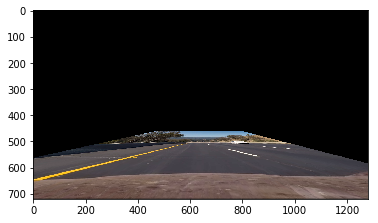

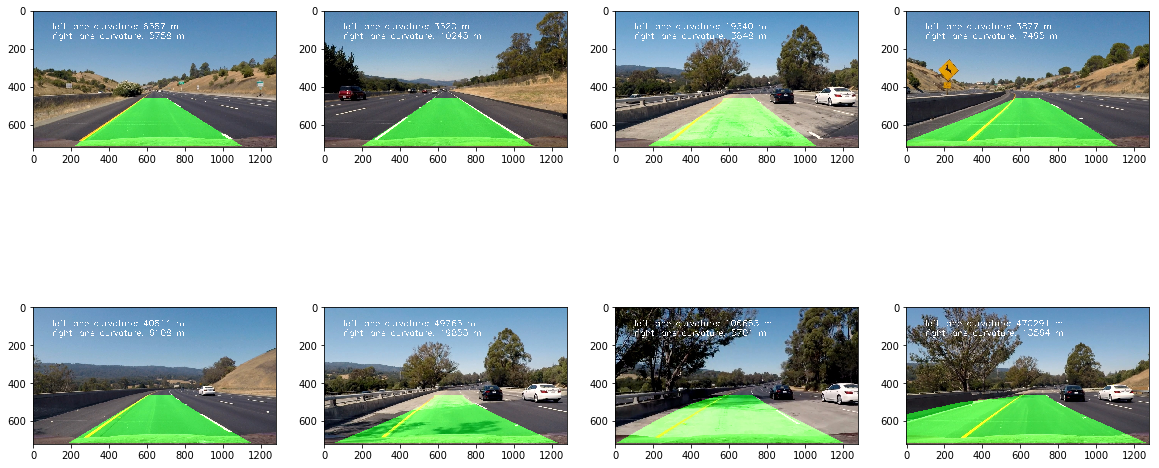

In [69]:
import matplotlib.pyplot as plt
from glob import glob

test_lane_finder = LaneFinder(camera_calibration_file="camera_cal/calibration_data.npy")
images = glob("test_images/*.jpg")

plt.figure(figsize=(20, 10))
for idx, image in enumerate(images):
    plt.subplot(2, len(images)//2, idx+1)
    image = cv2.imread(image)
    poly, frame = test_lane_finder.process_frame(image)
    overlay = test_lane_finder.get_lane_overlay(frame, poly)
    plt.imshow(overlay)
    img = cv2.addWeighted(frame, 1, overlay, 0.6, 0)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    lane_curvature = test_lane_finder.get_lane_curvature(poly)
    curvature_str1 = "left lane curvature: {:.0f} m".format(lane_curvature[0])
    curvature_str2 = "right lane curvature: {:.0f} m".format(lane_curvature[1])
    cv2.putText(img, curvature_str1,(100, 100), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (255, 255, 255), 2)
    cv2.putText(img, curvature_str2,(100, 150), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (255, 255, 255), 2)

    plt.imshow(img)
plt.show()

In [68]:
from moviepy.editor import VideoFileClip
import matplotlib.pyplot as plt

lane_finder = LaneFinder("test_videos/hard_patch.mp4", 
                         "camera_cal/calibration_data.npy")



# def process_image(image):
#     view = test_lane_finder.camera.birds_eye_view(image)
#     lines = test_lane_finder.isolator.isolate_lines(view)
#     return lines

def process_image(image):
    poly, frame = test_lane_finder.process_frame(image)
    overlay = test_lane_finder.get_lane_overlay(frame, poly)
    plt.imshow(overlay)
    img = cv2.addWeighted(frame, 1, overlay, 0.6, 0)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    lane_curvature = test_lane_finder.get_lane_curvature(poly)
    curvature_str1 = "left lane curvature: {:.0f} m".format(lane_curvature[0])
    curvature_str2 = "right lane curvature: {:.0f} m".format(lane_curvature[1])
    cv2.putText(img, curvature_str1,(100, 100), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (255, 255, 255), 2)
    cv2.putText(img, curvature_str2,(100, 150), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (255, 255, 255), 2)
    return img

clip = VideoFileClip('test_videos/hard_patch.mp4')
a_clip = clip.fl_image(process_image)
%time a_clip.write_videofile("lane_isolation1.mp4", audio=False)

[MoviePy] >>>> Building video lane_isolation1.mp4
[MoviePy] Writing video lane_isolation1.mp4



  0%|          | 1/550 [00:01<09:12,  1.01s/it]


KeyboardInterrupt: 

In [6]:
HTML("""
    <h1 style="font-family: sans-serif; padding: 20px 0; text-align: center">Output video</h1>
    <div style="width: 100%">
        <video style="width: inherit" controls autoplay loop src="lane_isolation1.mp4"/>
    </div>
    """)